# CIFAR10 Classification

### HW2 @ DL Course, Dr. Soleymani

*Full Name:* amir khazama

*SID:* 99105391

In this part of the assignment we want to do an image classification task using PyTorch on CIFAR10 dataset.

## Import Libraries

Import needed libraries

In [11]:
import torch
import torchvision

from torchvision import transforms

## Device

Set device to work with (GPU or CPU)

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [13]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [14]:
mean = [0.5, 0.5, 0.5]
std = [0.2, 0.2, 0.2]

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [15]:
# inverse the normilize transform to restore the original data
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for ch in range(tensor.size(0)):
            tensor[ch] = tensor[ch] * self.std[ch] + self.mean[ch]
        return tensor

norminv = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.20, 0.20, 0.20))

In [16]:
initial_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

100%|██████████| 170M/170M [00:01<00:00, 104MB/s]  


In [17]:
len(initial_trainset)

50000

frog


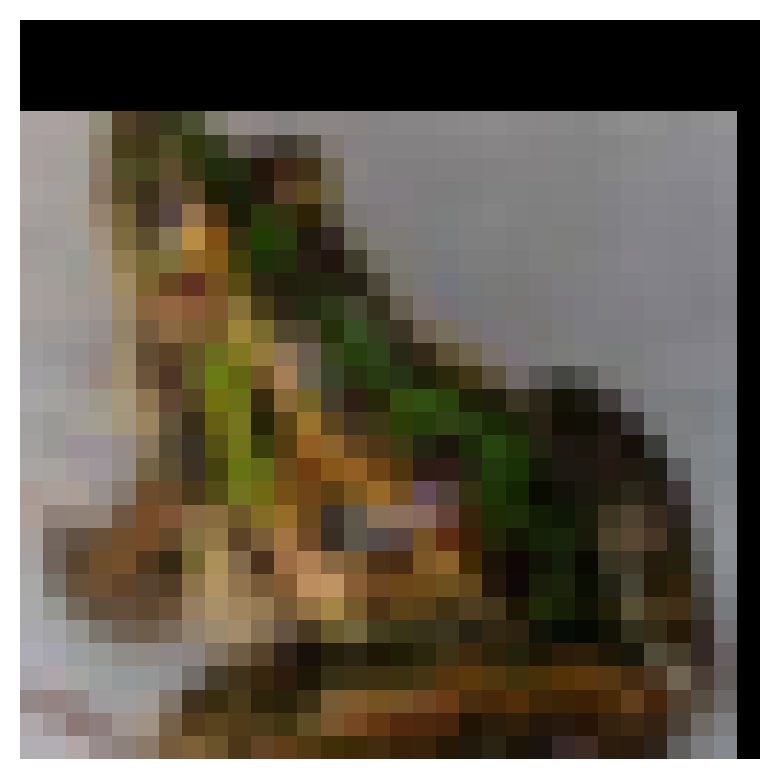

In [18]:
from matplotlib import pyplot as plt

plt.rcParams['figure.dpi'] = 200 # change dpi to make plots bigger
i = torch.randint(0, len(initial_trainset), (1,)).item()
img = norminv(initial_trainset[i][0]).permute(1,2,0)
plt.imshow(img)
plt.axis('off')
print(classes[initial_trainset[i][1]])

In [19]:
trainset, valset = torch.utils.data.random_split(initial_trainset, [0.9, 0.1])

In [20]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle= True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=128, num_workers=2)

In [23]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, num_workers=2)


## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

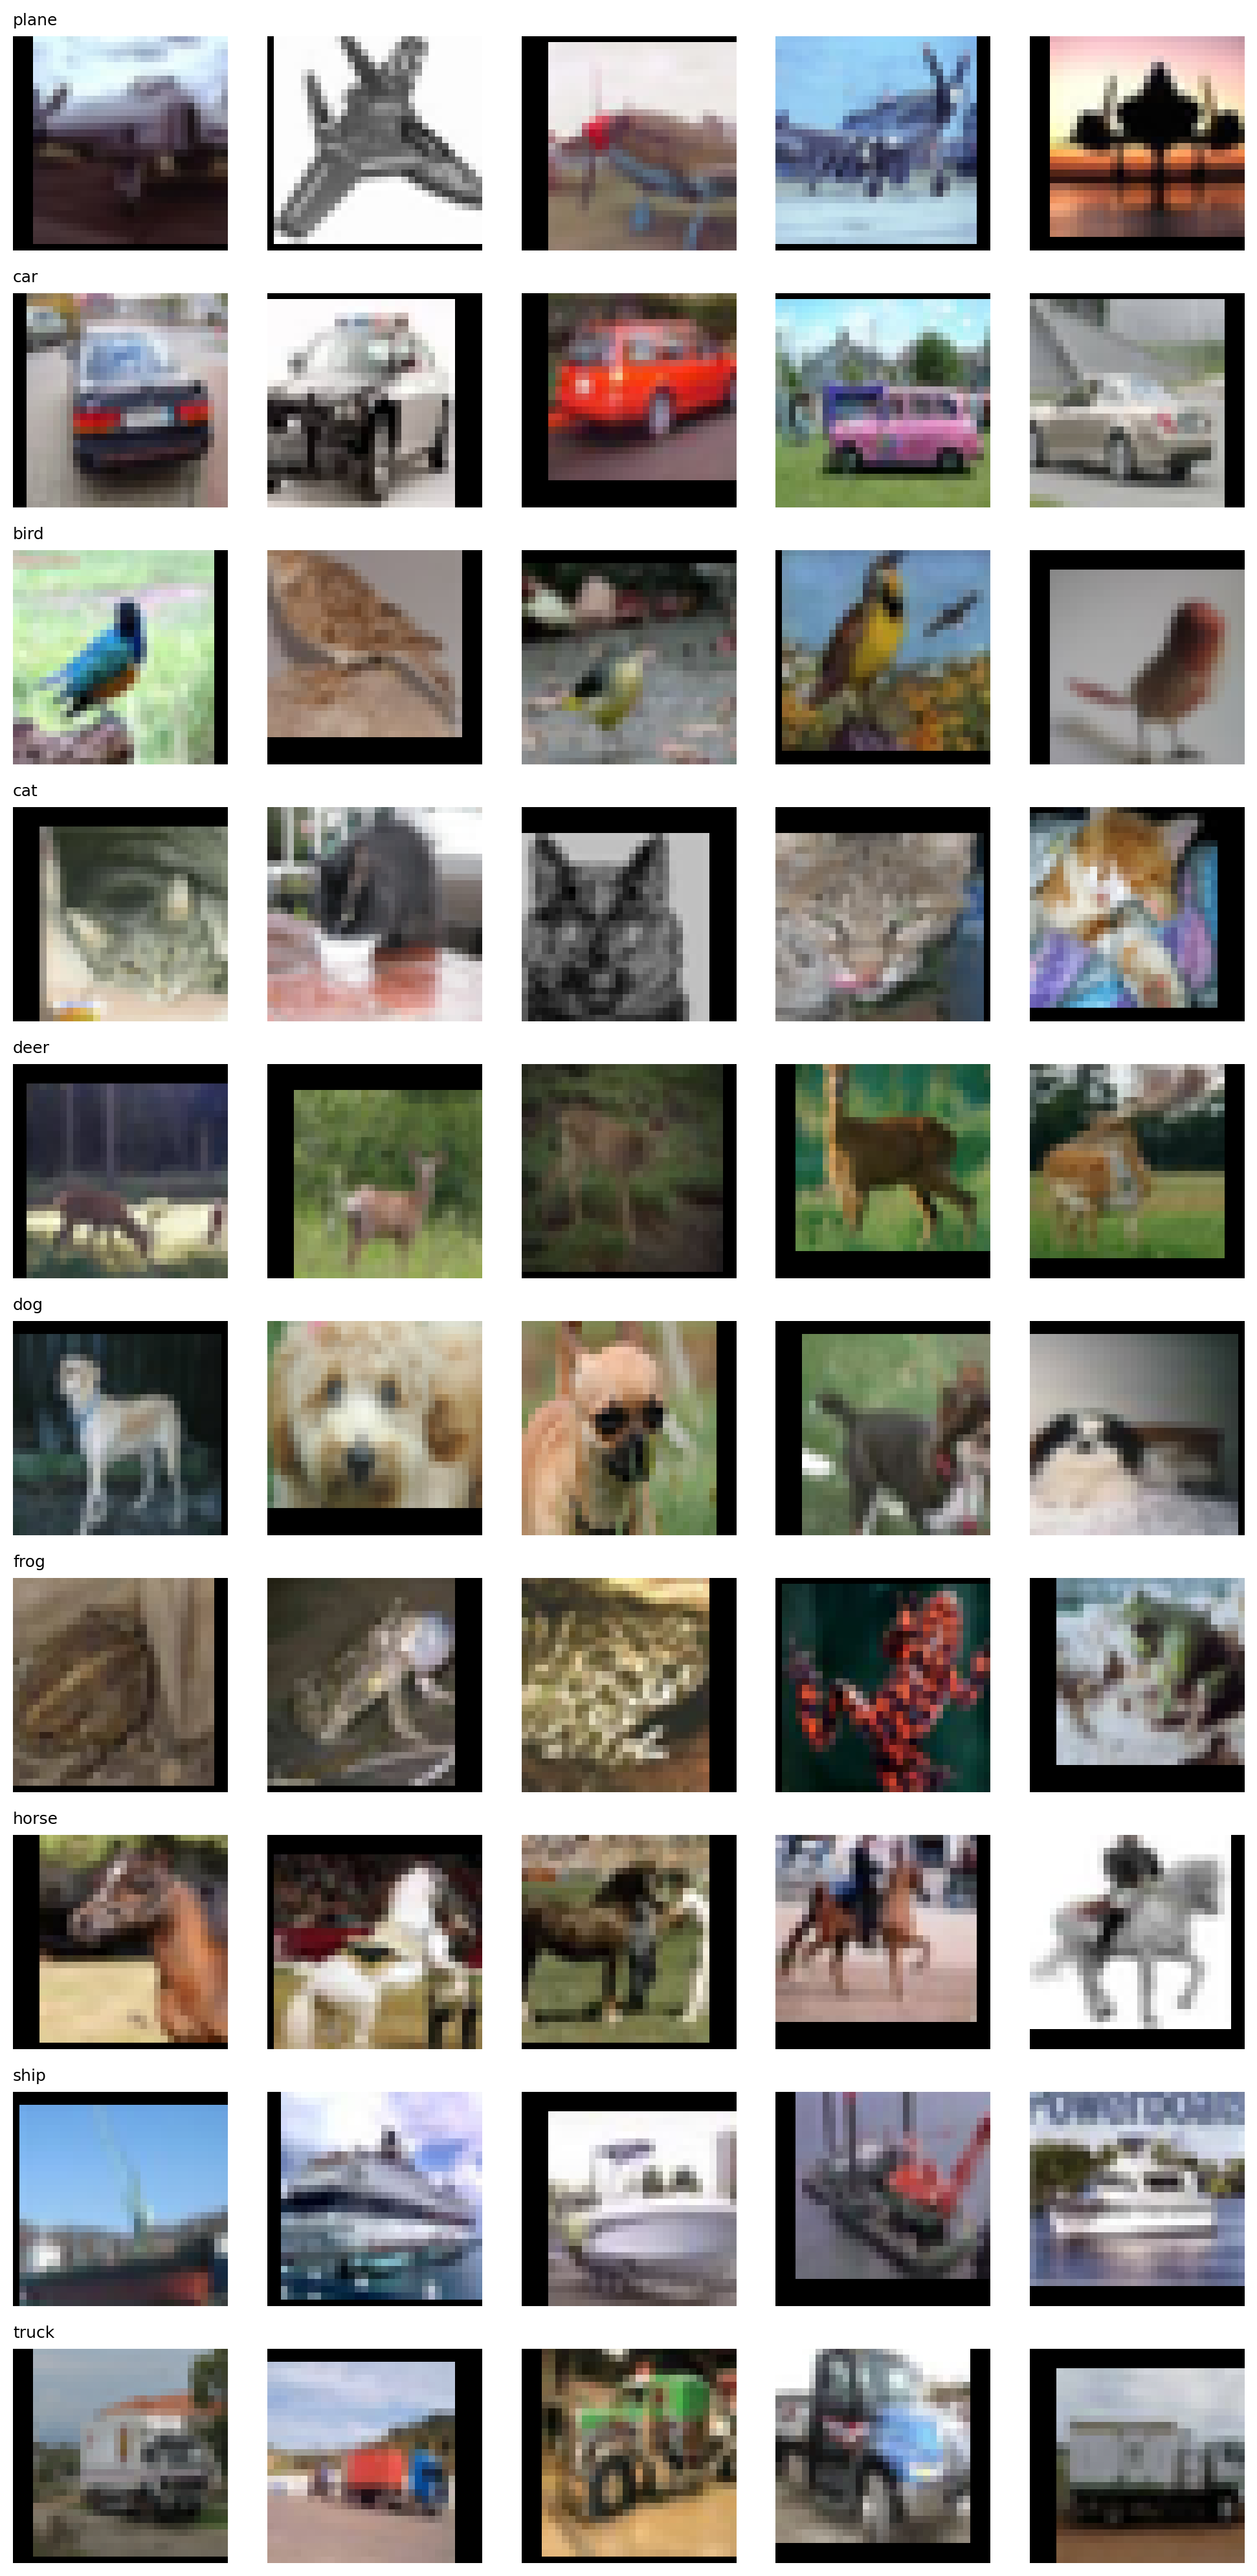

In [24]:
import random

imgs = {i:[] for i in range(len(classes))}


indices = list(range(len(initial_trainset)))
random.shuffle(indices)


for i in indices:
    img , cls = initial_trainset[i]
    if len(imgs[cls]) < 5:
        imgs[cls].append(norminv(img))
    if all(len(v) == 5 for v in imgs.values()):
        break

fig, axes = plt.subplots(10, 5, figsize=(10, 20))
for class_idx in range(10):
    for i in range(5):
        img = imgs[class_idx][i]
        img = img.permute(1, 2, 0).numpy()  # C,H,W → H,W,C
        axes[class_idx, i].imshow(img)
        axes[class_idx, i].axis('off')
        if i == 0:
            axes[class_idx, i].set_title(classes[class_idx], fontsize=9, loc='left')

plt.tight_layout()
plt.show()

## Model

Define your ResNet model here from scratch (You are not allowed to use the existing models in pytorch)

Our suggestion is to implement ResNet18

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = self.relu(out)

        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(3, 16, num_blocks=3, stride=1)
        self.layer2 = self._make_layer(16, 32, num_blocks=3, stride=2)
        self.layer3 = self._make_layer(32, 64, num_blocks=3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1)
        ) if stride != 1 or in_channels != out_channels else None

        layers.append(ResNetBlock(in_channels, out_channels, stride, downsample))
        for _ in range(1, num_blocks):
            layers.append(ResNetBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [26]:

net = ResNet18().to(device)

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

### Train loop

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [28]:
import tqdm
from time import time

In [29]:
def get_loss_and_correct(net, batch, criterion, device):
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    preds = torch.argmax(outputs, dim=1)
    correct = (preds == labels).sum()

    return loss, correct

# --- Backpropagation step ---
def step(net, loss, optimizer):
    optimizer.zero_grad()
    loss.backward()
    total_norm = 0.0
    for p in net.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    optimizer.step()
    return total_norm

In [30]:
def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer,scheduler: torch.optim.lr_scheduler ,dataloader: torch.utils.data.DataLoader):
    net.train()
    train_loss, train_correct = 0.0, 0
    grad_norms = []

    for batch in tqdm(dataloader, leave=False):
        loss, correct = get_loss_and_correct(net, batch, criterion, device)
        grad_norm = step(net , loss, optimizer)
        grad_norms.append(grad_norm)
        train_loss += loss.item()
        train_correct += correct.item()


    train_size = len(dataloader.dataset)
    mean_train_loss = train_loss / len(dataloader)
    train_accuracy = train_correct / train_size
    avrg_grad_norm = sum(grad_norms) / len(grad_norms)

    scheduler.step(mean_train_loss)
    
    return mean_train_loss, train_accuracy, avrg_grad_norm

def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
    net.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for batch in dataloader:
            loss, correct = get_loss_and_correct(net, batch, criterion, device)
            val_loss += loss.item()
            val_correct += correct.item()


    val_size = len(dataloader.dataset)
    mean_val_loss = val_loss / len(dataloader)
    val_accuracy = val_correct / val_size

    if test_mode:
        print(f"Test Loss: {mean_val_loss:.4f}")
        print(f"Test Accuracy: {val_accuracy * 100:.2f}%")
    
    return mean_val_loss, val_accuracy


In [31]:
from tqdm.notebook import tqdm


epochs = 300
early_stop_patience = 30
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_path = "best_model.pth"

train_losses, train_accuracies = [], []
validation_losses, validation_accuracies = [], []
grad_norms_per_epoch = []


pbar = tqdm(range(epochs))
for e in pbar:
    mean_train_loss, train_accuracy , avrg_grad_norm = train_epoch(net, criterion, optimizer ,scheduler, trainloader)
    train_losses.append(mean_train_loss)
    train_accuracies.append(train_accuracy)
    grad_norms_per_epoch.append(avrg_grad_norm)


    mean_val_loss, val_accuracy = eval_epoch(net, criterion, valloader)
    validation_losses.append(mean_val_loss)
    validation_accuracies.append(val_accuracy)


    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        epochs_without_improvement = 0

        torch.save(net.state_dict(), best_model_path)
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= early_stop_patience:
        print(f"Early stopping at epoch {e+1}")
        break

    pbar.set_postfix({
        'train_acc': train_accuracy,
        'val_acc': val_accuracy,
        'lr': optimizer.param_groups[0]['lr'],
        'grad_norm':grad_norms_per_epoch[-1],
        'train_loss': mean_train_loss,
        'val_loss': mean_val_loss,
    })


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

Early stopping at epoch 112


In [33]:
net.load_state_dict(torch.load("best_model.pth"))
net.eval()

ResNet18(
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): AvgPool2d(kernel_size=3, stride=1, padding=1)
      )
    )
    (1): ResNetBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affi

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

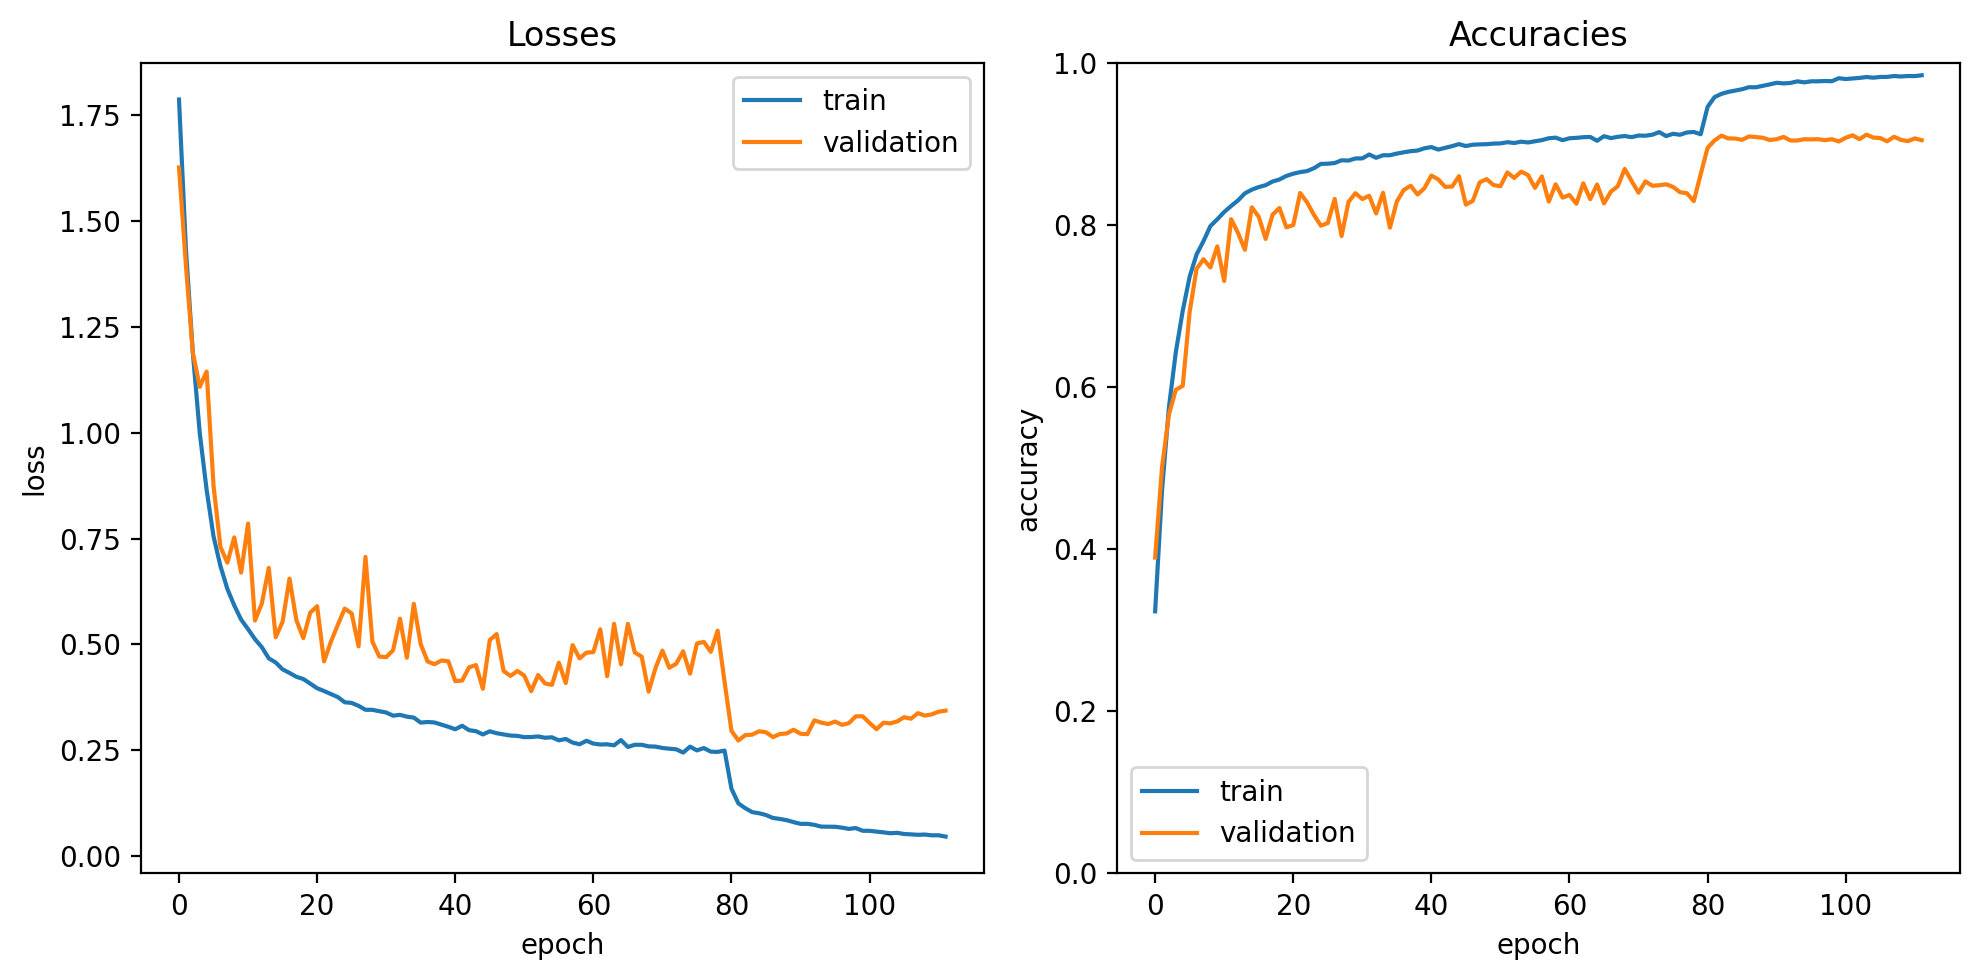

In [35]:


plt.figure(dpi=200, figsize=(10, 5))

plt.subplot(121)
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses')
plt.legend()

plt.subplot(122)
plt.plot(train_accuracies, label='train')
plt.plot(validation_accuracies, label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('Accuracies')

plt.tight_layout()
plt.show()

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `80%`

In [64]:
eval_epoch(net, criterion, testloader, test_mode=True)

Test Loss: 0.3616
Test Accuracy: 88.96%


(0.36159064686751063, 0.8896)

## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model

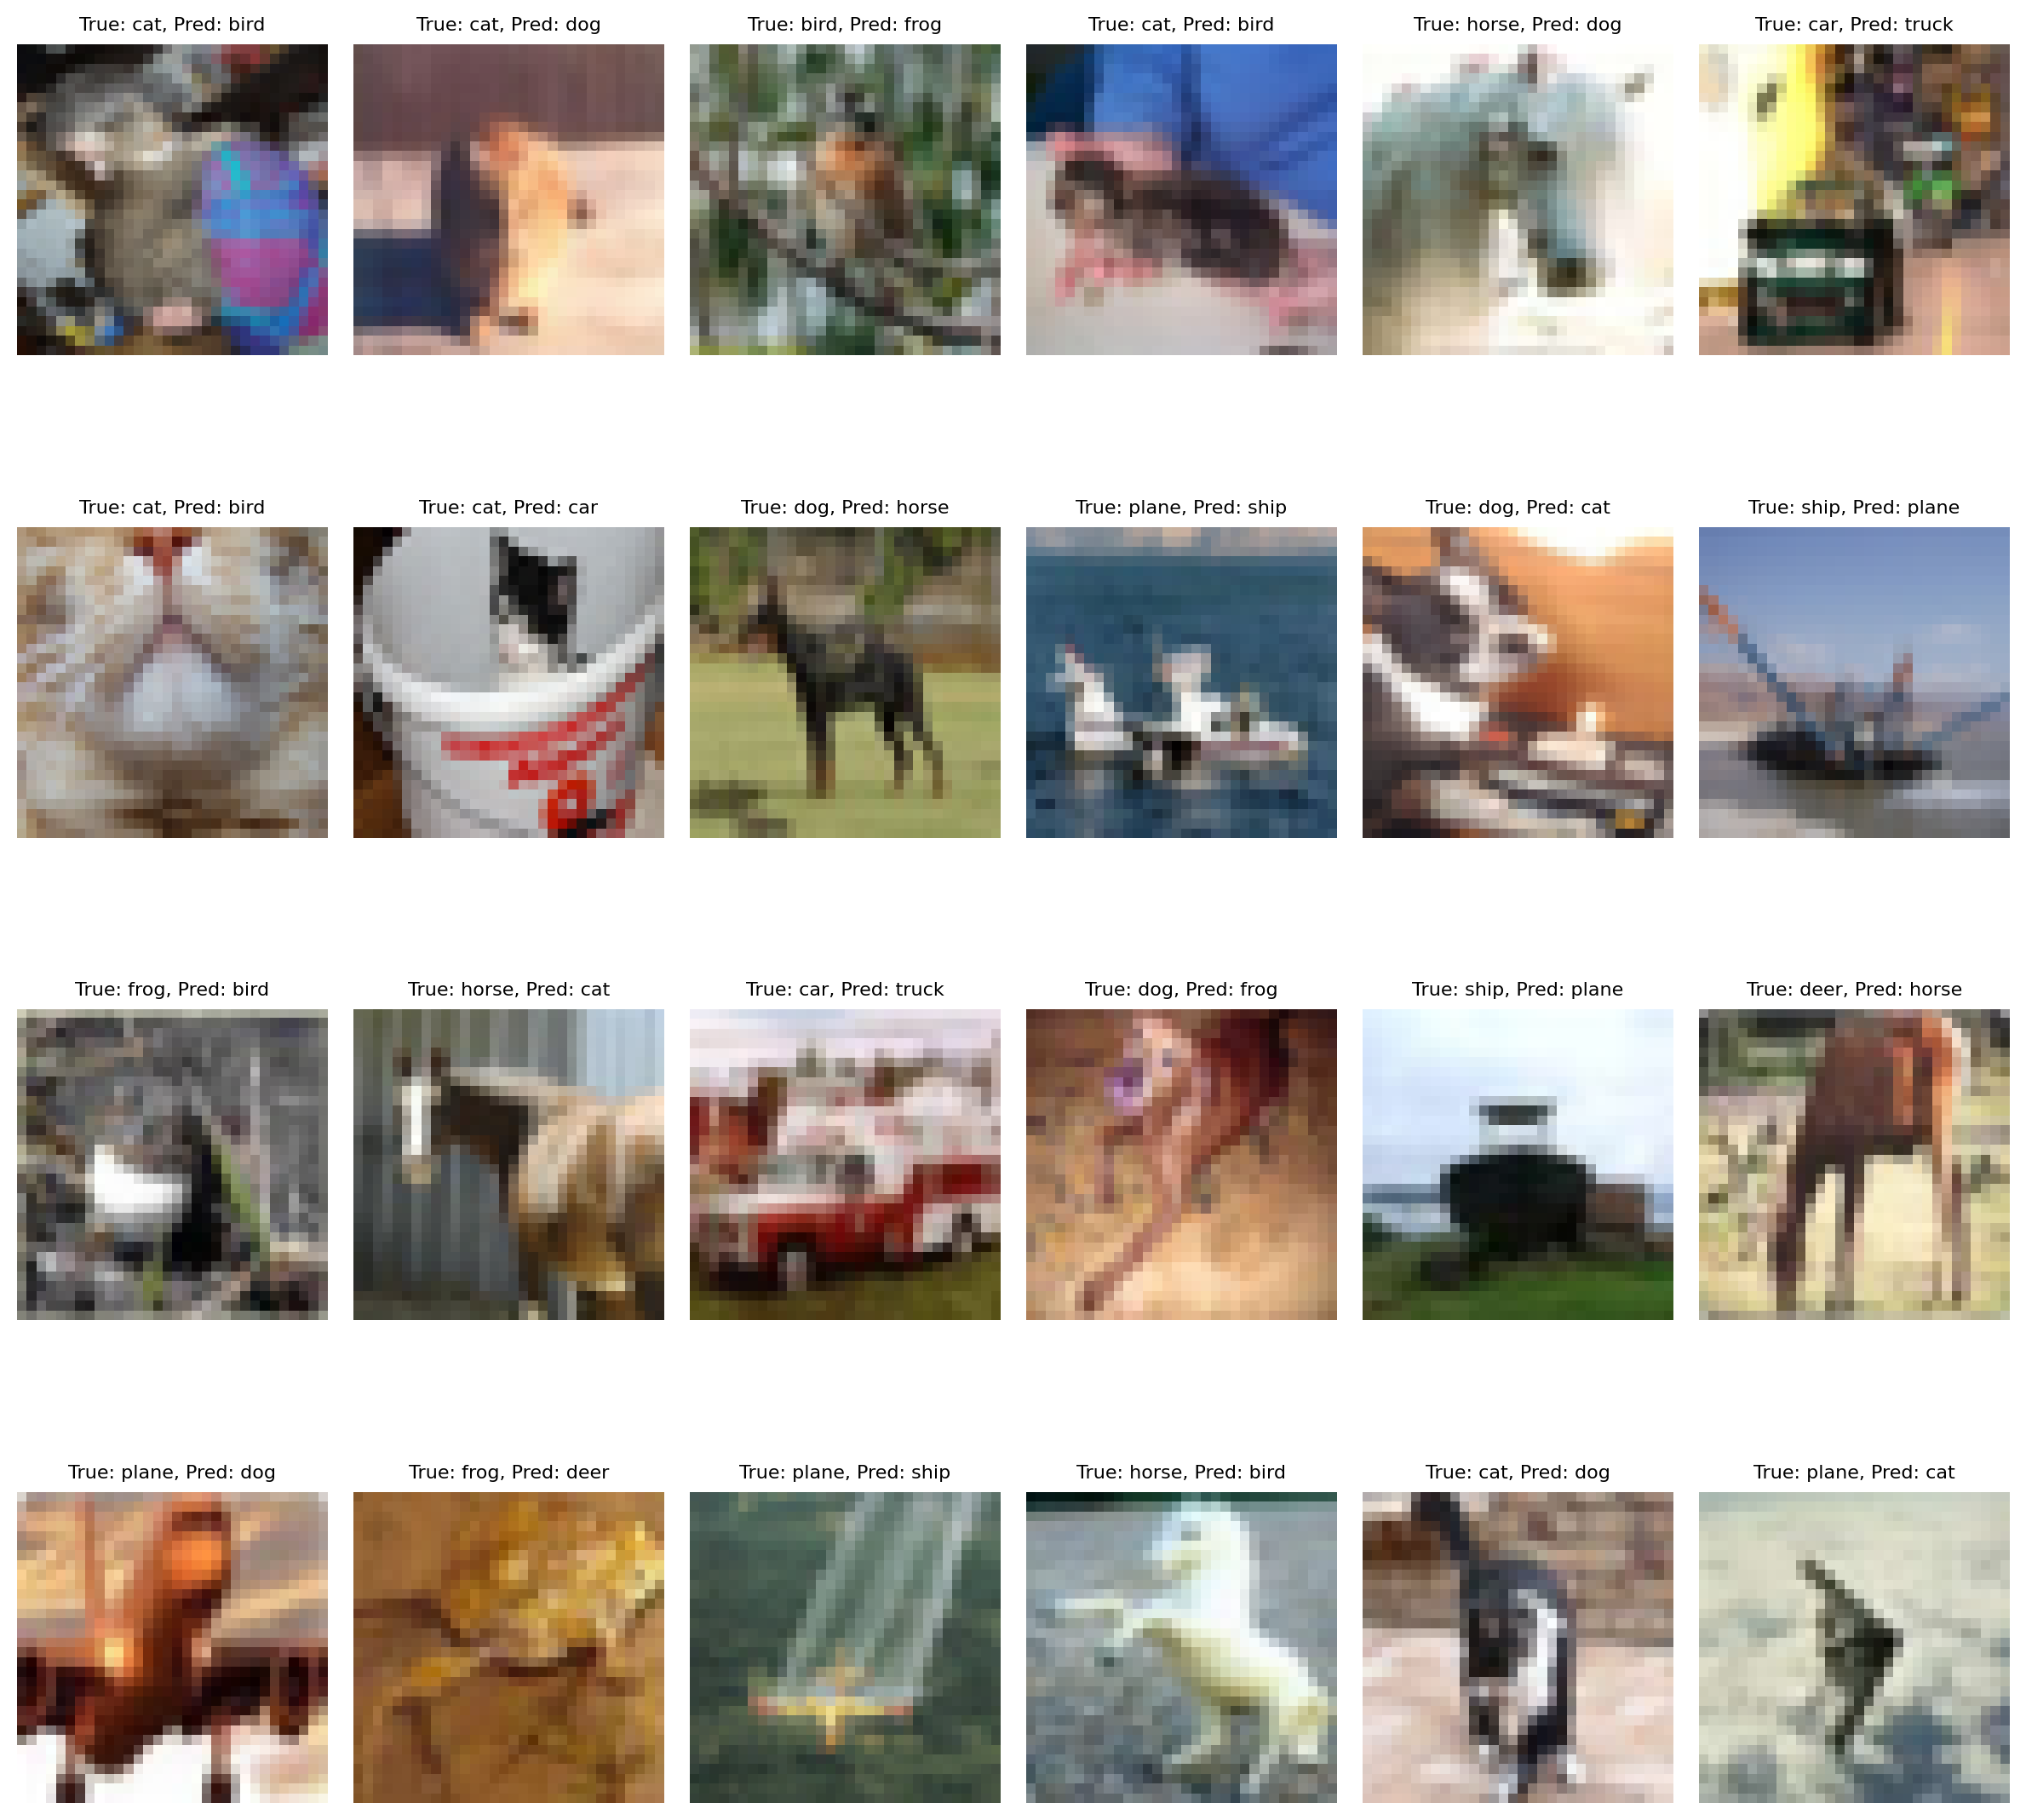

In [36]:
# Put model in evaluation mode
net.eval()

misclassified_images = []
misclassified_preds = []
misclassified_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        preds = outputs.argmax(dim=1)

        # Find misclassified indices
        incorrect = preds != labels
        if incorrect.any():
            misclassified_images.extend(inputs[incorrect].cpu())
            misclassified_preds.extend(preds[incorrect].cpu())
            misclassified_labels.extend(labels[incorrect].cpu())

# Randomly select 24 misclassified samples
indices = random.sample(range(len(misclassified_images)), 24)

# Plot them
plt.figure(figsize=(12, 12))
for i, idx in enumerate(indices):
    img = norminv(misclassified_images[idx])
    true_label = classes[misclassified_labels[idx].item()]
    pred_label = classes[misclassified_preds[idx].item()]

    plt.subplot(4, 6, i + 1)
    img = img.permute(1, 2, 0)  # CxHxW → HxWxC
    plt.imshow(img.numpy())
    plt.title(f'True: {true_label}, Pred: {pred_label}', fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

# CIFAR10 Colorization

In this part of the assignment, we want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

In [87]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [88]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Custom Dataset

Define a custom dataset class by extensing `torch.utils.data.Dataset`

**Notice:** your dataset should output two things: black-and-white image and the RGB image

**Hint:** You don't have to reinvent the wheel. Your class should just be a wrapper for CIFAR10 dataset

In [89]:
from torch.utils.data import Dataset

In [90]:
class BlackAndWhiteCIFAR10(Dataset):
    """
    Define a custom dataset class by extending `torch.utils.data.Dataset`
    this class is a dataset for the CIFAR10 data in pytorch and it has the black and white image of the original CIFAR10 image as the data
    and the original RGB image as the target
    this class is just a wrapper for the torchvision.datasets.CIFAR10 class
    """

    def __init__(self, train=True, root='./data', download=True, transform=None):
        self.base_cifar = torchvision.datasets.CIFAR10(root='./data', train=train,
                                        download=download, transform=transform)
        
        self.to_gray = transforms.Grayscale(num_output_channels=1)
    def __len__(self):
        return len(self.base_cifar)

    def __getitem__(self, index):
        base_img, _ = self.base_cifar[index]
        gray_img = self.to_gray(base_img)
        return gray_img , base_img

## Transforms & Dataset & Dataloader

**Notice:** Use your defined custom dataset class for defining the datasets

In [91]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [92]:
mean = [0.5, 0.5, 0.5]
std = [0.2, 0.2, 0.2]

transform_train =  transforms.Compose([
        transforms.Pad(8, padding_mode='reflect'),
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),  # ±15° rotation, ±10% shift
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(32),  # crop center back to original size
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

In [93]:
initial_trainset = BlackAndWhiteCIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

In [94]:
trainset, valset = torch.utils.data.random_split(initial_trainset, [0.9, 0.1])

In [95]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle= True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, num_workers=2)

## Dataset Visualization

Visualize your dataset (black-and-white image along with the RGB image) by sampling from your trainset

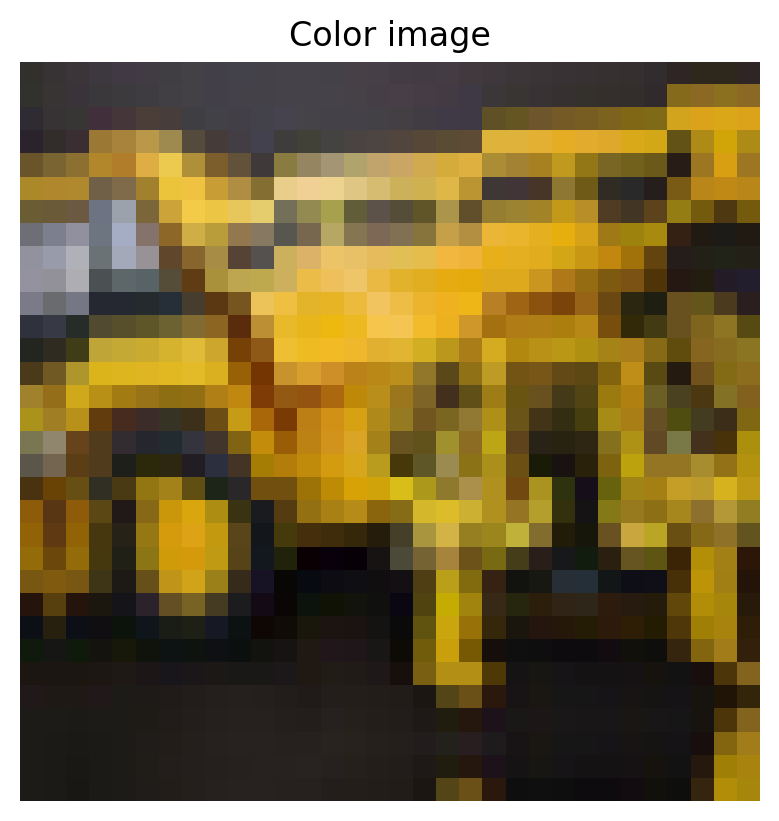

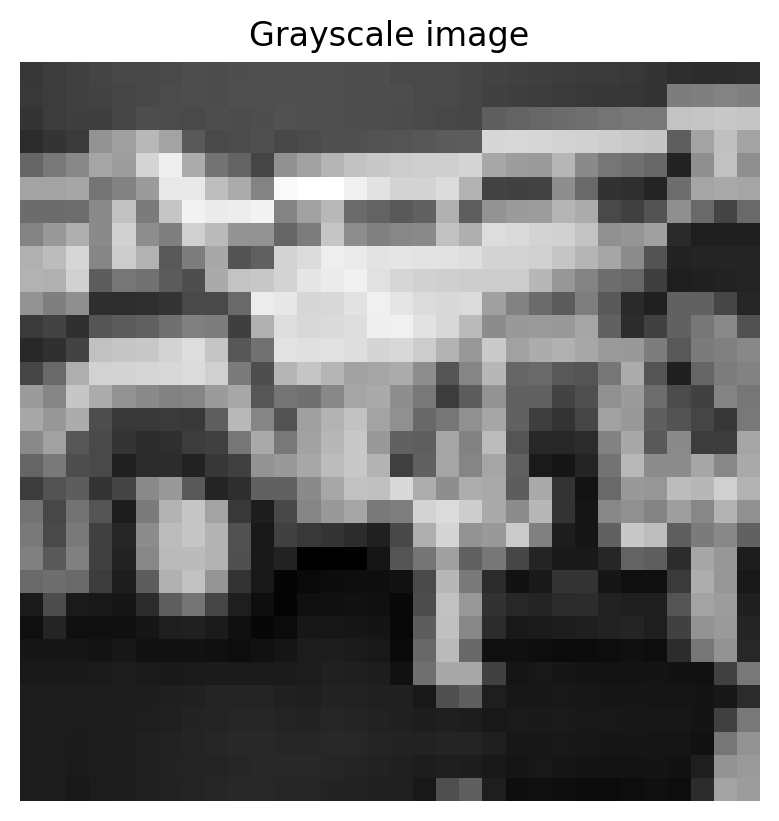

In [96]:
from matplotlib import pyplot as plt

plt.rcParams['figure.dpi'] = 200 # change dpi to make plots bigger
i = torch.randint(0, len(initial_trainset), (1,)).item()
gray_norm , color_norm = initial_trainset[i]
gray_UnNorm = (gray_norm * std[0])+mean[0]
color = norminv(color_norm).permute(1,2,0)
# Plot color image
plt.figure()
plt.title("Color image")
plt.imshow(color)
plt.axis('off')

# Plot grayscale image
plt.figure()
plt.title("Grayscale image")
plt.imshow(gray_UnNorm.squeeze(), cmap='gray')  # Remove channel dim if needed
plt.axis('off')

plt.show()

## Model

Define your model here (Input: black-and-white image, Output: RGB image)

**Hint:** You can implement an autoencoder that does the colorization task for you. UNet could be a viable option

In [97]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same', padding_mode='reflect'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same', padding_mode='reflect'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class TransConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransConvBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(in_channels, out_channels)  # concat doubles channels -> in_channels

    def forward(self, x, skip_input):
        x = self.upconv(x)
        # Concatenate along channel dimension
        x = torch.cat([x, skip_input], dim=1)
        x = self.conv_block(x)
        return x

class colorizationNet(nn.Module):
    def __init__(self, input_channels=1, output_channels=3, base_filters=64, dropout_rate=0.5):
        super(colorizationNet, self).__init__()

        # Downsampling
        self.conv1 = ConvBlock(input_channels, base_filters)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = ConvBlock(base_filters, base_filters*2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = ConvBlock(base_filters*2, base_filters*4)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            ConvBlock(base_filters * 4, base_filters * 8),
            nn.Dropout2d(dropout_rate)
        )


        # Upsampling
        self.upconv3 = TransConvBlock(base_filters*8, base_filters*4)
        self.upconv2 = TransConvBlock(base_filters*4, base_filters*2)
        self.upconv1 = TransConvBlock(base_filters*2, base_filters)

        # Final conv (to output channels)
        self.final_conv = nn.Conv2d(base_filters, output_channels, kernel_size=1)

    def forward(self, x):
        # Downsampling path
        c1 = self.conv1(x)
        p1 = self.pool1(c1)

        c2 = self.conv2(p1)
        p2 = self.pool2(c2)

        c3 = self.conv3(p2)
        p3 = self.pool3(c3)

        # Bottleneck
        b = self.bottleneck(p3)

        # Upsampling path with skip connections
        u3 = self.upconv3(b, c3)
        u2 = self.upconv2(u3, c2)
        u1 = self.upconv1(u2, c1)

        out = self.final_conv(u1)
        return out


## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [98]:
net = colorizationNet().to(device)

In [99]:
criterion = nn.MSELoss()  # common for colorization regression, you can also try L1Loss or others
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)  # adjust LR as needed

In [100]:
import tqdm
from time import time

In [101]:
def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer ,dataloader: torch.utils.data.DataLoader):
    net.train()
    grad_norms = []
    running_loss = 0.0
    for inputs, targets in tqdm.tqdm(dataloader, leave=False):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)  # outputs shape: [batch, 3, H, W]
        loss = criterion(outputs, targets)
        loss.backward()
        total_norm = 0.0
        for p in net.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        grad_norms.append(total_norm)
        
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss, sum(grad_norms) / len(grad_norms)

def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
    net.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


In [102]:
epochs = 40

early_stop_patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_path = "best_Unet.pth"

    

train_losses , val_losses, grad_norms =[],[],[] 
for e in range(epochs):
    train_loss , avrg_grad_norm= train_epoch(net, criterion, optimizer, trainloader)
    val_loss = eval_epoch(net, criterion, valloader)

    print(f"Epoch {e+1}/{epochs} — Train Loss: {train_loss:.4f} — Val Loss: {val_loss:.4f} - Grad Norm: {avrg_grad_norm:.4}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    grad_norms.append(avrg_grad_norm)


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0

        torch.save(net.state_dict(), best_model_path)
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= early_stop_patience:
        print(f"Early stopping at epoch {e+1}")
        break

Epoch 1/40 — Train Loss: 0.1624 — Val Loss: 0.1330 - Grad Norm: 0.6036


Epoch 2/40 — Train Loss: 0.1517 — Val Loss: 0.1281 - Grad Norm: 0.5441


Epoch 3/40 — Train Loss: 0.1491 — Val Loss: 0.1301 - Grad Norm: 0.5188


Epoch 4/40 — Train Loss: 0.1471 — Val Loss: 0.1306 - Grad Norm: 0.4946


Epoch 5/40 — Train Loss: 0.1469 — Val Loss: 0.1298 - Grad Norm: 0.4892


Epoch 6/40 — Train Loss: 0.1450 — Val Loss: 0.1342 - Grad Norm: 0.4678


Epoch 7/40 — Train Loss: 0.1427 — Val Loss: 0.1257 - Grad Norm: 0.4429


Epoch 8/40 — Train Loss: 0.1424 — Val Loss: 0.1272 - Grad Norm: 0.4364


Epoch 9/40 — Train Loss: 0.1405 — Val Loss: 0.1266 - Grad Norm: 0.4156


Epoch 10/40 — Train Loss: 0.1382 — Val Loss: 0.1245 - Grad Norm: 0.3903


Epoch 11/40 — Train Loss: 0.1372 — Val Loss: 0.1203 - Grad Norm: 0.379


Epoch 12/40 — Train Loss: 0.1341 — Val Loss: 0.1257 - Grad Norm: 0.3458


Epoch 13/40 — Train Loss: 0.1307 — Val Loss: 0.1194 - Grad Norm: 0.3092


Epoch 14/40 — Train Loss: 0.1284 — Val Loss: 0.1219 - Grad Norm: 0.2897


Epoch 15/40 — Train Loss: 0.1266 — Val Loss: 0.1222 - Grad Norm: 0.2695


Epoch 16/40 — Train Loss: 0.1254 — Val Loss: 0.1191 - Grad Norm: 0.2569


Epoch 17/40 — Train Loss: 0.1245 — Val Loss: 0.1179 - Grad Norm: 0.2476


Epoch 18/40 — Train Loss: 0.1239 — Val Loss: 0.1170 - Grad Norm: 0.2434


Epoch 19/40 — Train Loss: 0.1228 — Val Loss: 0.1178 - Grad Norm: 0.2335


Epoch 20/40 — Train Loss: 0.1224 — Val Loss: 0.1193 - Grad Norm: 0.2331


Epoch 21/40 — Train Loss: 0.1219 — Val Loss: 0.1173 - Grad Norm: 0.2291


Epoch 22/40 — Train Loss: 0.1212 — Val Loss: 0.1226 - Grad Norm: 0.2187


Epoch 23/40 — Train Loss: 0.1203 — Val Loss: 0.1164 - Grad Norm: 0.2156


Epoch 24/40 — Train Loss: 0.1203 — Val Loss: 0.1141 - Grad Norm: 0.217


Epoch 25/40 — Train Loss: 0.1198 — Val Loss: 0.1168 - Grad Norm: 0.2108


Epoch 26/40 — Train Loss: 0.1188 — Val Loss: 0.1164 - Grad Norm: 0.207


Epoch 27/40 — Train Loss: 0.1185 — Val Loss: 0.1148 - Grad Norm: 0.2062


Epoch 28/40 — Train Loss: 0.1178 — Val Loss: 0.1142 - Grad Norm: 0.2001


Epoch 29/40 — Train Loss: 0.1174 — Val Loss: 0.1140 - Grad Norm: 0.2032


Epoch 30/40 — Train Loss: 0.1168 — Val Loss: 0.1156 - Grad Norm: 0.1985


Epoch 31/40 — Train Loss: 0.1166 — Val Loss: 0.1137 - Grad Norm: 0.1982


Epoch 32/40 — Train Loss: 0.1162 — Val Loss: 0.1146 - Grad Norm: 0.1974


Epoch 33/40 — Train Loss: 0.1153 — Val Loss: 0.1157 - Grad Norm: 0.191


Epoch 34/40 — Train Loss: 0.1157 — Val Loss: 0.1125 - Grad Norm: 0.1941


Epoch 35/40 — Train Loss: 0.1153 — Val Loss: 0.1149 - Grad Norm: 0.1949


Epoch 36/40 — Train Loss: 0.1140 — Val Loss: 0.1123 - Grad Norm: 0.1844


Epoch 37/40 — Train Loss: 0.1137 — Val Loss: 0.1123 - Grad Norm: 0.1881


Epoch 38/40 — Train Loss: 0.1133 — Val Loss: 0.1134 - Grad Norm: 0.1804


Epoch 39/40 — Train Loss: 0.1131 — Val Loss: 0.1119 - Grad Norm: 0.1849


Epoch 40/40 — Train Loss: 0.1129 — Val Loss: 0.1136 - Grad Norm: 0.1899


In [103]:
net.load_state_dict(torch.load("best_Unet.pth"))
net.eval()

colorizationNet(
  (conv1): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
      (4): BatchNorm2d(128, eps=1e-05, mo

### Visualize Loss plot

Using the arrays that you have (from task 2 in the above section), visualize the loss plot (train and validation together)

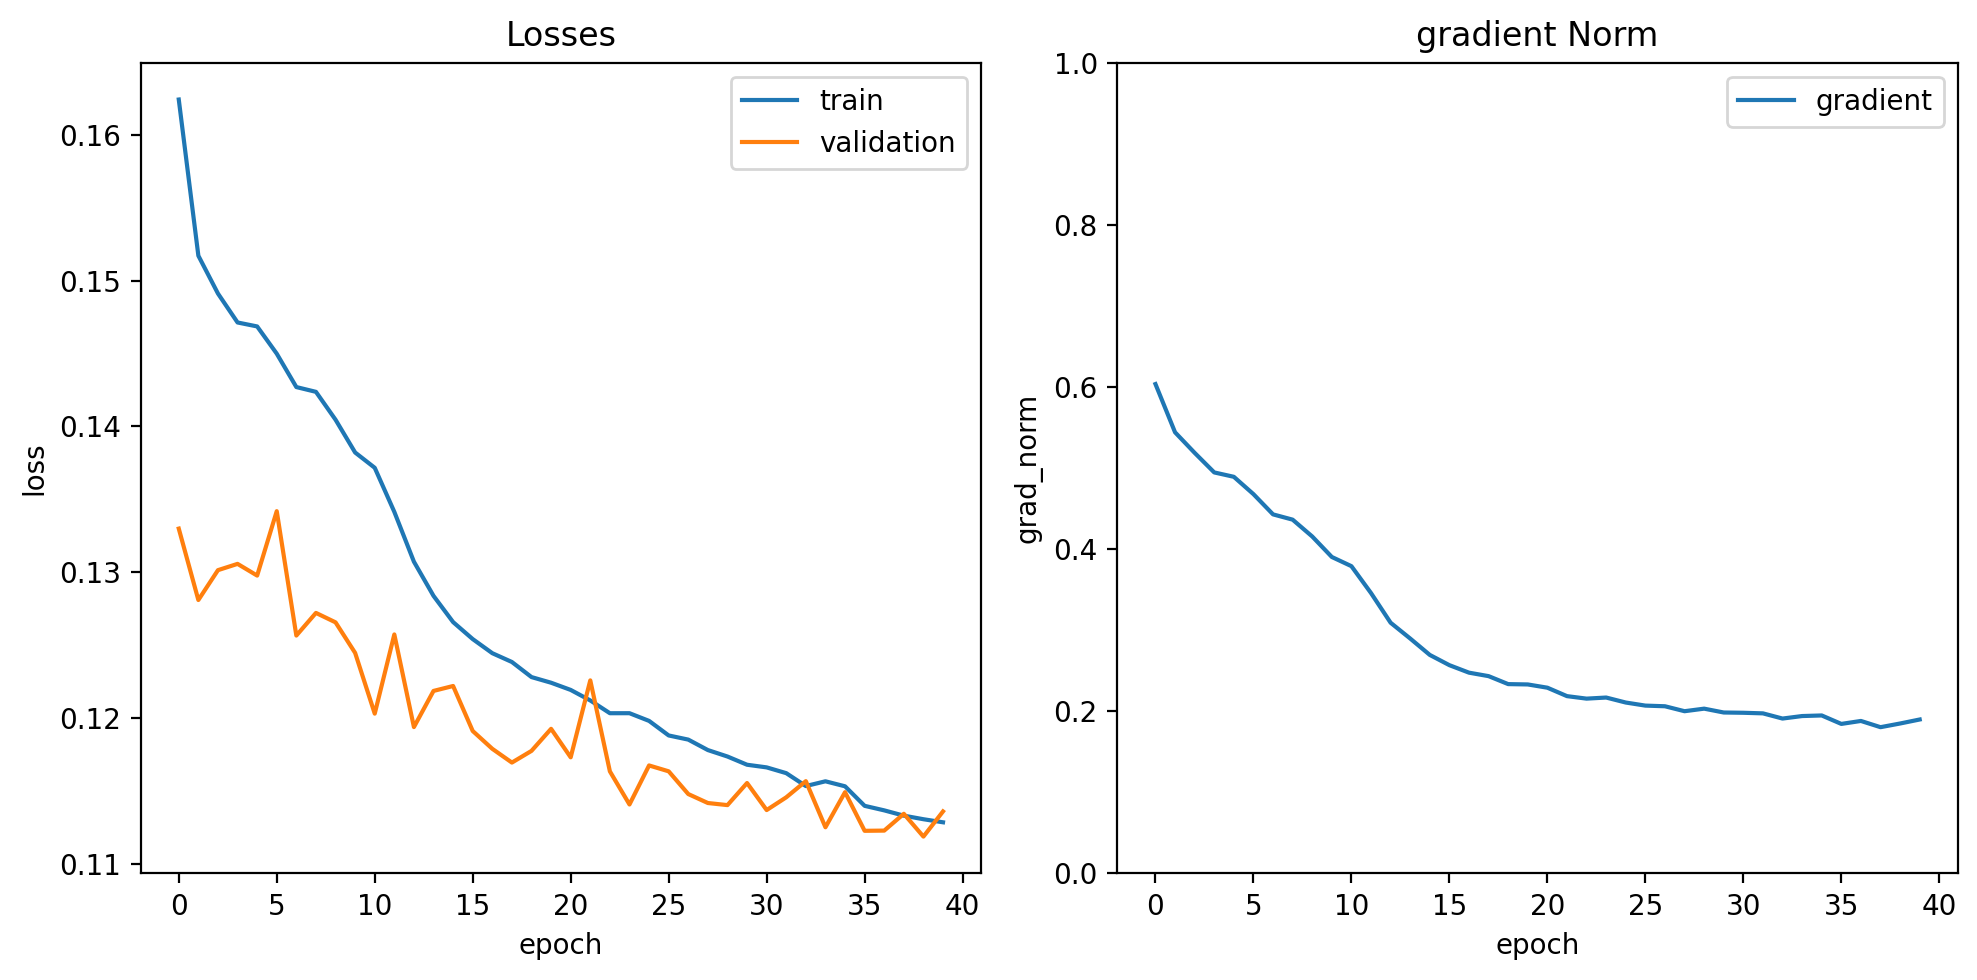

In [105]:

train_losses , val_losses, grad_norms
plt.figure(dpi=200, figsize=(10, 5))

plt.subplot(121)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses')
plt.legend()

plt.subplot(122)
plt.plot(grad_norms, label='gradient')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('grad_norm')
plt.ylim(0, 1)
plt.title('gradient Norm')

plt.tight_layout()
plt.show()

## Evaluation

1. Sample 36 random samples from testset (your own dataset class)
2. Give each of the 36 samples to your trained model and get the outputs
3. Visualize `input` (black-and-white image), `output` (output of the model with the given black-and-white input image) and `ground truth` (the actual RGB image)



In [106]:
testset = BlackAndWhiteCIFAR10(train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True, num_workers=2)


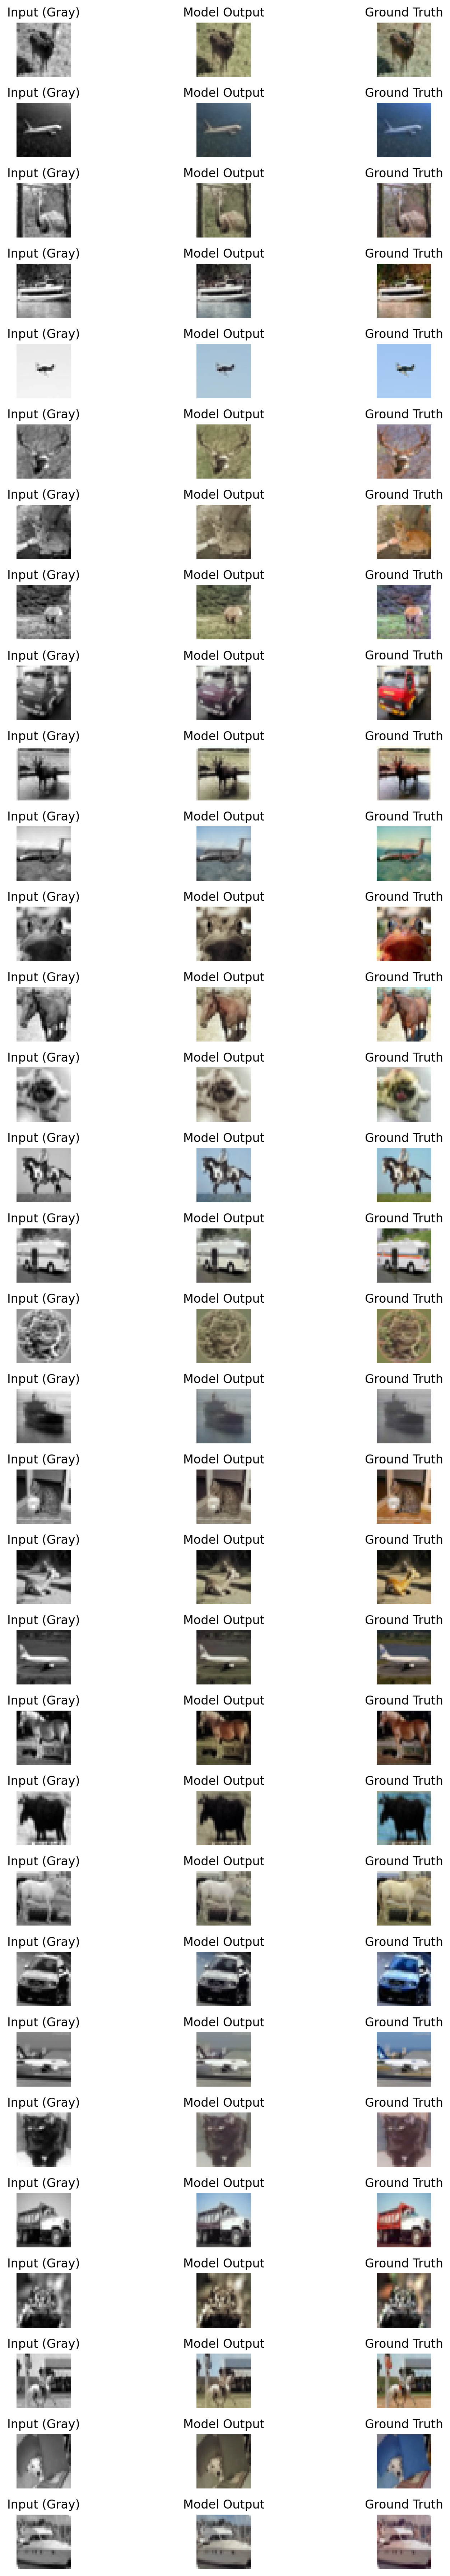

In [112]:
fig, axes = plt.subplots(32, 3, figsize=(9, 36))  # 12 rows (each with input, output, target)

net.eval()

with torch.no_grad():
    gray_imgs, color_imgs = next(iter(testloader))

    gray_imgs = gray_imgs.to(device)  # add batch dim
    output_imgs = net(gray_imgs)

        # # Unnormalize
        # gray_np = gray_img.squeeze().numpy()
        # output_np = unnormalize(output_tensor).permute(1, 2, 0).clip(0, 1).numpy()
        # target_np = unnormalize(color_img).permute(1, 2, 0).clip(0, 1).numpy()

    for i in range(gray_imgs.size(0)):

        A = (gray_imgs[i].squeeze() * std[0])+mean[0]
        B = norminv(output_imgs[i]).permute(1,2,0)
        C = norminv(color_imgs[i]).permute(1,2,0)
            
        axes[i, 0].imshow(A.cpu(), cmap='gray')
        axes[i, 0].set_title("Input (Gray)")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(B.cpu())
        axes[i, 1].set_title("Model Output")
        axes[i, 1].axis('off')
    
        axes[i, 2].imshow(C.cpu())
        axes[i, 2].set_title("Ground Truth")
        axes[i, 2].axis('off')

plt.tight_layout()
plt.show()